In [63]:
import pandas as pd 
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [64]:
data = pd.read_csv('spotify.csv', na_values=['-', ' ', ''])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   released_year         953 non-null    int64  
 2   in_spotify_playlists  953 non-null    int64  
 3   in_spotify_charts     951 non-null    float64
 4   streams               953 non-null    int64  
 5   in_apple_playlists    953 non-null    int64  
 6   in_apple_charts       951 non-null    float64
 7   bpm                   953 non-null    int64  
 8   mode                  953 non-null    object 
 9   energy                953 non-null    int64  
 10  instrumentalness      953 non-null    int64  
 11  liveness              953 non-null    int64  
 12  speechiness           953 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 96.9+ KB
None


In [65]:
thirdQuantile = data['streams'].quantile(0.75)
data['HighStreams'] = (data['streams'] > thirdQuantile).astype(int)
# data['HighStreams'] = np.where(data['streams'] > thirdQuantile, 1, 0)
print(data['HighStreams'].head())

0    0
1    0
2    0
3    1
4    0
Name: HighStreams, dtype: int32


In [66]:
print(data['in_spotify_charts'].head())
print(data['in_apple_charts'].head())

ps = shapiro(data['in_spotify_charts'].dropna())
print(ps)
ps = shapiro(data['in_apple_charts'].dropna())
print(ps)

sm = data['in_spotify_charts'].median()
data['in_spotify_charts'].fillna(sm, inplace=True)

am = data['in_apple_charts'].median()
data['in_apple_charts'].fillna(am, inplace=True)

0    147.0
1     48.0
2    113.0
3      NaN
4     50.0
Name: in_spotify_charts, dtype: float64
0    263.0
1    126.0
2    207.0
3    207.0
4    133.0
Name: in_apple_charts, dtype: float64
ShapiroResult(statistic=0.665931224822998, pvalue=1.4519175687516224e-39)
ShapiroResult(statistic=0.8839384317398071, pvalue=4.468788251553773e-26)


In [67]:
data.drop(columns=['track_name'], inplace=True)

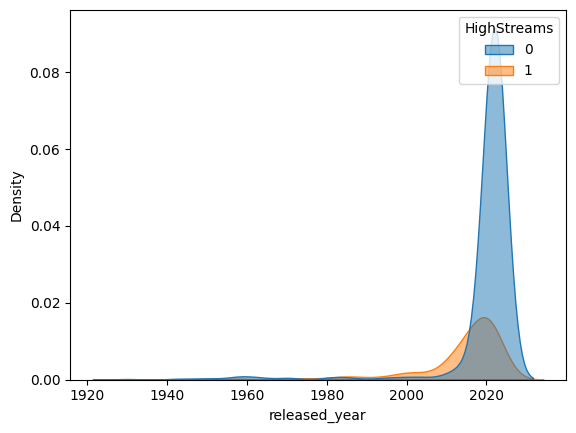

In [68]:
# plt.figure(figsize=(6,4))
# KDE - Kernel Density Estimate
sns.kdeplot(data=data, x='released_year', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Most songs are released around 2020 in our dataset
# There is a lot more low stream songs

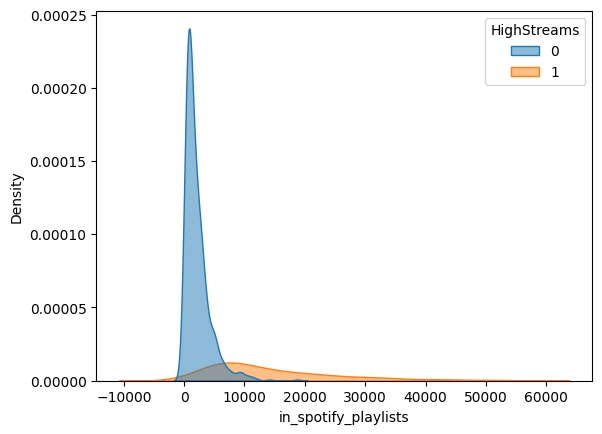

In [69]:
sns.kdeplot(data=data, x='in_spotify_playlists', hue='HighStreams', fill=True, alpha=0.5)
plt.show()

In [70]:
data.drop(columns='bpm', inplace=True)
data.drop(columns='liveness', inplace=True)
data.drop(columns='energy', inplace=True)
data.drop(columns='instrumentalness', inplace=True)
data.drop(columns='speechiness', inplace=True)

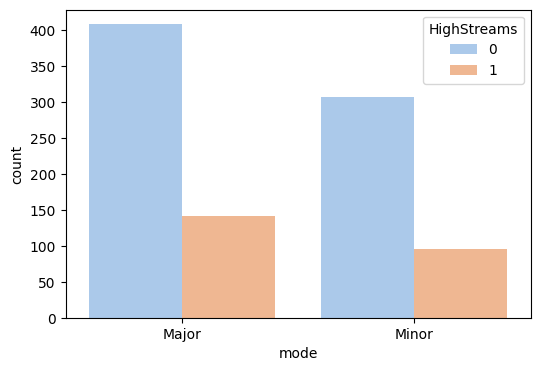

In [71]:
# If it was the case that in minor and major there is the same proportion of high and low stream songs, we would drop that column too
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='mode', hue='HighStreams', palette='pastel')

plt.show()

In [72]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   released_year         953 non-null    int64  
 1   in_spotify_playlists  953 non-null    int64  
 2   in_spotify_charts     953 non-null    float64
 3   streams               953 non-null    int64  
 4   in_apple_playlists    953 non-null    int64  
 5   in_apple_charts       953 non-null    float64
 6   mode                  953 non-null    object 
 7   HighStreams           953 non-null    int32  
dtypes: float64(2), int32(1), int64(4), object(1)
memory usage: 56.0+ KB
None


In [73]:
numeric_vars = ['released_year', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts']

In [74]:
# Standardization or Normalization? 
# Normalization (min-max scaling) rescales data based on the minimum and maximum values.
# Standardization (z-score scaling) centers the data around the mean and scales by standard deviation.
# When we have a lot of outliers, it's better to use Standardization.

# BITWISE EXAMPLE
# a = pd.Series([True, False, True, False])
# b = pd.Series([False, False, True, True])

# result_or = a | b    # element-wise OR
# result_and = a & b   # element-wise AND

# print(result_or)  
# # 0     True
# # 1    False
# # 2     True
# # 3     True
# # dtype: bool

# OR/AND EXAMPLE
# a = True
# b = False

# if a or b:
#     print("At least one is True")

# if a and b:
#     print("Both are True")

for num_var in numeric_vars:
    q1 = data[num_var].quantile(0.25)
    q3 = data[num_var].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    number_of_outliers = ((data[num_var] < lower) | (data[num_var] > upper)).sum()
    print(number_of_outliers)

151
109
76
78
12


In [75]:
print(data.describe())

       released_year  in_spotify_playlists  in_spotify_charts       streams  \
count     953.000000            953.000000         953.000000  9.530000e+02   
mean     2018.238195           5200.124869          11.853095  5.141928e+08   
std        11.116218           7897.608990          19.320751  5.665617e+08   
min      1930.000000             31.000000           0.000000  2.762000e+03   
25%      2020.000000            875.000000           0.000000  1.417210e+08   
50%      2022.000000           2224.000000           3.000000  2.908332e+08   
75%      2022.000000           5542.000000          16.000000  6.738011e+08   
max      2023.000000          52898.000000         147.000000  3.703895e+09   

       in_apple_playlists  in_apple_charts  HighStreams  
count          953.000000       953.000000   953.000000  
mean            67.812172        51.665268     0.249738  
std             86.441493        50.376630     0.433088  
min              0.000000         0.000000     0.000000 

In [76]:
# The Shapiro–Wilk test (often used via scipy.stats.shapiro) is a statistical test for normality — it checks whether your data looks like it came from a normal (Gaussian) distribution.

# shapiro_results = data[numeric_vars].apply(lambda x: shapiro(x)[1])
# print("Shapiro-Wilk p-vrednosti:\n", shapiro_results)

[print(shapiro(data[nv])[1]) for nv in numeric_vars]

0.0
2.585255536832855e-41
1.284532467188023e-39
4.262229766486136e-37
4.332553822114851e-26


[None, None, None, None, None]

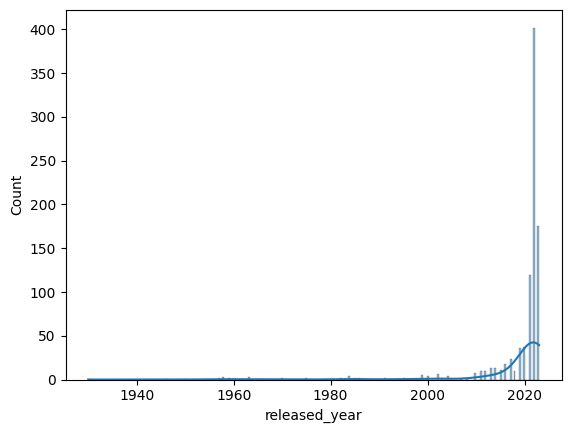

In [77]:
sns.histplot(data['released_year'], kde=True)
plt.show()

In [78]:
# Unlike StandardScaler (which uses mean & standard deviation), RobustScaler uses the median and interquartile range (IQR) for scaling.
robust_scaler = RobustScaler()
data_st = pd.DataFrame()
data_st[numeric_vars] = robust_scaler.fit_transform(data[numeric_vars])

In [79]:
data_st['mode'] = data['mode'].map({'Major': 0, 'Minor': 1})

In [80]:
data_st['HighStream'] = data['HighStreams']

In [81]:
X = data_st.drop(columns='HighStream')
y = data_st['HighStream']
# The parameter stratify=y in the train_test_split function means the split will preserve the distribution of the classes in y across both the training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [82]:
# In k-Nearest Neighbors (kNN), the k value tells the algorithm how many neighbors to look at before making a decision.
knn = KNeighborsClassifier()

# GridSearchCV from sklearn.model_selection is a hyperparameter tuning tool
# In KNN a hyperparameter is k

param_grid = { 'n_neighbors': list(range(3, 26, 2)) }

cv = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    verbose=1, # Controls how much info gets printed while the search is running.
    n_jobs=-1 # Controls parallelism — how many CPU cores to use for running fits in parallel
)

cv.fit(X_train, y_train)
best_k = cv.best_params_['n_neighbors']
print(best_k)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
3


In [83]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[136   7]
 [ 11  37]]


In [84]:
def compute_eval_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return {
        'accuracy': accuracy,
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }

In [85]:
knn_eval = compute_eval_metrics(y_test, y_pred)
print(knn_eval)

{'accuracy': 0.9057591623036649, 'precision': 0.8409090909090909, 'recall': 0.7708333333333334, 'f1': 0.8043478260869565}
